# Goals

* Use map-reduce-subgraph framework with SRA tools agent

In [40]:
# import 
import os
import re
import time
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [41]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)

# Tools

In [42]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

In [43]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    #organism: Annotated[str, "Organism name ('human' or 'mouse')"]="human",
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    """
    # date range
    start_date = datetime.now() - timedelta(days=7)
    end_date = datetime.now()
    date_range = f"{start_date.strftime('%Y/%m/%d')}:{end_date.strftime('%Y/%m/%d')}[PDAT]"
    esearch_query += f" AND {date_range}"

    max_ids = 4  # DEBUG

    # query
    ids = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            ids.extend(search_results["IdList"])
            retstart += retmax
            time.sleep(0.5)
            if max_ids and len(ids) >= max_ids:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
    # return IDs
    return ids[:max_ids]  # debug

#query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
#IDs = esearch.invoke({"esearch_query" : query, "database" : "sra"})
#IDs

In [44]:
@tool 
def efetch(
    database: Annotated[str, "Database name ('sra' or 'gds')"],
    entrez_id: Annotated[str, "Entrez ID"],
    )-> Annotated[List[str], "eFetch results in xml format"]:
    """
    Run an Entrez efetch query on an Entrez ID to obtain metadata for the record.
    """
    time.sleep(0.5)
    # Fetch dataset record
    try:
        handle = Entrez.efetch(db=database, id=entrez_id, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to fetch record for {entrez_id}")
    finally:
        handle.close()
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass

    # check for errors
    if "Error occurred: cannot get document summary" in record:
        return f"Failed to fetch record for {entrez_id}. Try a different database (gds or sra)."

    return str(record)

#record = efetch.invoke({"database" : "sra", "entrez_id" : "35966237"})
#pprint(record)
#record = efetch.invoke({"database" : "gds", "entrez_id" : "200254051"})
#pprint(record)

In [45]:
@tool 
def get_pubmed_article(
    pubmed_id: Annotated[str, "PubMed ID"],
    )-> Annotated[str, "PubMed article metadata in xml format"]:
    """
    Get a PubMed article using Entrez efetch.
    """
    handle = Entrez.efetch(db="pubmed", id=pubmed_id, retmode="xml")
    record = handle.read()
    handle.close()
    try:
        record = record.decode("utf-8")
    except:
        pass
    return str(record)

#get_pubmed_article.invoke({"pubmed_id" : "39492543"})


In [46]:
from subprocess import Popen, PIPE

def run_cmd(cmd: str) -> tuple:
    """
    Run sub-command and return returncode, output, and error.
    Args:
        cmd: Command to run
    Returns:
        tuple: (returncode, output, error)
    """
    p = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()
    return p.returncode, output, err

In [47]:
import time

@tool
def run_sra_stat(
    accession: Annotated[str, "SRA accession"],
    tries: Annotated[int, "Number of attempts"]=3
    ) -> str: 
    """
    Run the sra-stat CLI command (SRA Tools) on an SRA accession.
    Use this tool to get information about the sequence data associated with the SRA accession.
    """
    cmd = f'sra-stat --xml --quick {accession}'
    err = ""
    for i in range(tries):
        rc,output,err = run_cmd(cmd)
        if rc == 0:
            return output.decode("utf-8")
        # sleep prior to next attempt
        sleep_time = 5 * (i + 1)
        time.sleep(sleep_time)
    return f"Failed to run sra-stat: {err}"

#run_sra_stat.invoke({"accession" : "SRR13112659"})

In [48]:
@tool 
def geo2sra(
    entrez_id: Annotated[str, "Entrez ID for a GEO dataset"],
    )-> Annotated[List[str], "List linked Entrez IDs for SRA records"]:
    """
    Convert a GEO Entrez ID to SRA Entrez IDs.
    """
    # Fetch detailed GEO record to get links to SRA
    handle = Entrez.elink(dbfrom="gds", db="sra", id=entrez_id)
    links = Entrez.read(handle)
    handle.close()
        
    sra_ids = []
    if links[0]['LinkSetDb']:
        sra_ids = [link['Id'] for link in links[0]['LinkSetDb'][0]['Link']]

    return sra_ids

    # Get SRA accessions from IDs
    sra_accessions = []
    for sra_id in sra_ids:
        handle = Entrez.esummary(db="sra", id=sra_id)
        summary = Entrez.read(handle)
        handle.close()
        # Extract SRA accessions from summary
        for entry in summary:
            try:
                run_xml = entry["Runs"]
            except KeyError:
                continue
            
            hit = re.search(r'Run acc="([A-Z]+\d+)"', run_xml)
            if hit:
                sra_accessions.append(hit.group(1))
        # Add delay to comply with NCBI's guidelines
        time.sleep(0.34) 
    if len(sra_accessions) == 0:
        return "No SRA accessions found."

    # return a list of SRA accessions
    return sra_accessions

#geo2sra.invoke({"entrez_id" : "200254051"})
#geo2sra.invoke({"entrez_id" : "200268899"})

# Graph

In [49]:
import operator
from typing import Annotated, Sequence, Tuple, Union, Required
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [50]:
# set model
model = ChatOpenAI(model="gpt-4o-mini")

## Subgraph

In [51]:
class SubState(TypedDict):
    """
    Shared state of the agents in the subgraph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    accessions: Annotated[List[str], "SRA accessions associated with the dataset"]
    is_single_cell: Annotated[bool, "Whether the dataset is a single-cell RNA-seq dataset"]
    explanation: Annotated[str, "Concise determination on whether the dataset is actually a single-cell RNA-seq dataset"]

In [52]:
# create react agent
research_agent = create_react_agent(
    model=model,
    tools=[efetch, run_sra_stat, get_pubmed_article, geo2sra],
    state_modifier=(
        "Based on the provided Entrez record ID, fetch inforamtion about the database record."
        " Use your tools to determine if the dataset is a single-cell RNA-seq dataset."
        " Generally, you will want to use the efetch tool first to get the metadata of the record."
        " Keep researching until you have a clear answer or you have run out of tools."
        " If the provided Entrez record is a GEO dataset (database = 'gds'),"
        " you will need to use the geo2sra tool to get the associated SRA accessions."
    )
)

In [53]:
class ResearchSummary(TypedDict):
    """
    Summarize the research results.
    """
    accessions: List[str]
    is_single_cell: bool
    explanation: str 

In [54]:
def summarize_research(state: SubState) -> str:
    """
    Summarize the research results by incorporating previous conversation history.
    """
    # Create a prompt template that includes previous messages
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You will be provided with information on a dataset that may be a single-cell RNA-seq dataset."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", ("Based on the information above, determine whether this dataset is truly a single-cell RNA-seq dataset."
            " Also, provide a concise explanation and any relevant accessions.")
        ),
    ])

    # Format the prompt with the message history
    formatted_prompt = prompt.format_messages(
        history=state["messages"]
    )

    # Use the formatted prompt with the LLM
    return model.with_structured_output(ResearchSummary, strict=True).invoke(formatted_prompt)

# invoke the function
state = {
    "messages": [
        HumanMessage(content="The accession is SRR13112659. The dataset is from a single-cell RNA-seq experiment."),
    ],
    "determination": ""
}
# summarize_research(state)

In [55]:
#-- subgraph --#
subworkflow = StateGraph(SubState)

# nodes
subworkflow.add_node("research_agent_node", research_agent)
subworkflow.add_node("research_summary_node", summarize_research)

# edges
subworkflow.add_edge(START, "research_agent_node")
subworkflow.add_edge("research_agent_node", "research_summary_node")
subworkflow.add_edge("research_summary_node", END)

# compile the graph
subgraph = subworkflow.compile()

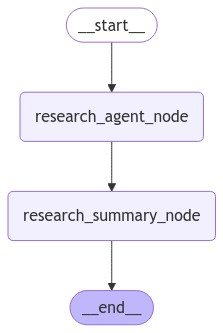

In [56]:
from IPython.display import Image
Image(subgraph.get_graph().draw_mermaid_png())

In [57]:
# Function to invoke the subgraph
def invoke_subgraph(state: SubState):
    message = HumanMessage(content=f"Entrez ID: {state['entrez_id']}, Database: {state['database']}")
    response = subgraph.invoke({"messages" : [message]})
    return {
        "accessions": [response["accessions"]],
        "is_single_cell": [response["is_single_cell"]],
        "explanations": [response["explanation"]]
    }

#ret = invoke_subgraph({"entrez_id" : "36004814", "database" : "sra"})
#ret = invoke_subgraph({"entrez_id" : "35966233", "database" : "sra"})
#ret

In [58]:
# GEO record ID
#ret = invoke_subgraph({"entrez_id" : "200268899", "database" : "gds"})
#ret

## Graph

In [59]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    database: str
    # esearch IDs
    entrez_ids: Annotated[List[str], operator.add]
    # accessions
    accessions: Annotated[List[List[str]], operator.add]
    # is_single_cell
    is_single_cell: Annotated[List[bool], operator.add]
    # explanations
    explanations: Annotated[List[str], operator.add]

In [60]:
def run_esearch(state: TopState):
    query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
    entrez_ids = esearch.invoke({"esearch_query" : query, "database" : state["database"]})
    return {"entrez_ids" : entrez_ids}

# Here we define the logic to map out over the generated subjects
def continue_to_subgraphs(state: TopState):
    return [Send("invoke_subgraph", {"entrez_id": x, "database" : state["database"]}) for x in state["entrez_ids"]]

def final_state(state: TopState):
    return {
        "database": state["database"],
        "entrez_ids": state["entrez_ids"],
        "accessions": state["accessions"],
        "is_single_cell": state["is_single_cell"],
        "explanations": state["explanations"]
    }

In [61]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("esearch_node", run_esearch)
workflow.add_node("invoke_subgraph", invoke_subgraph)
workflow.add_node("final_state_node", final_state)

# edges
workflow.add_edge(START, "esearch_node")
workflow.add_conditional_edges("esearch_node", continue_to_subgraphs, ["invoke_subgraph"])
workflow.add_edge("invoke_subgraph", "final_state_node")
workflow.add_edge("final_state_node", END)

# compile the graph
graph = workflow.compile()

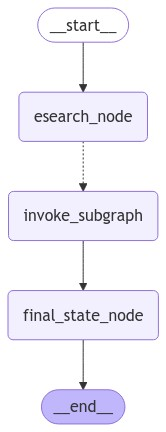

In [62]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph
final_state = None
for step in graph.stream({"database": "sra"}, subgraphs=True, config={"max_concurrency" : 2, "recursion_limit": 30}):
    print(step)
    final_state = step

((), {'esearch_node': {'entrez_ids': ['36004814', '36004694', '36004643', '36004624']}})
(('invoke_subgraph:f9dcbc45-a36f-1306-6f0d-1b1cdaf62c9c', 'research_agent_node:ac2fc15f-9907-e127-b27c-9da096d599dd'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r2Q823xkHsVf9FIcg56ylLNG', 'function': {'arguments': '{"database":"sra","entrez_id":"36004814"}', 'name': 'efetch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 345, 'total_tokens': 369, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_9b78b61c52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb5bcaac-210d-4bd8-b8c6-1c05e21ecd33-0', tool_calls=[{'name': 'efetch', 'args': {'database': 'sr

In [64]:
# get final state
final_state

((),
 {'final_state_node': {'database': 'sra',
   'entrez_ids': ['36004814', '36004694', '36004643', '36004624'],
   'accessions': [['ERX13336124', 'ERP165048', 'ERS21882372', 'ERR13934242'],
    ['ERP165048', 'ERX13336120', 'ERS21882368', 'ERR13934238'],
    ['ERX13336135', 'ERP165048', 'ERS21882383'],
    ['ERX13336129', 'ERP165048', 'ERS21882377']],
   'is_single_cell': [True, True, True, True],
   'explanations': ['The dataset involves single-cell RNA sequencing performed on splenocytes, aiming to analyze changes in immune cell composition and function. The library source explicitly indicates it is transcriptomic single cell.',
    "The dataset involves single-cell RNA sequencing of splenocytes, as indicated in the library source (Transcriptomic single cell) and the study title, which explicitly mentions 'Single cell RNA sequencing'. This confirms that the dataset is indeed focused on single-cell RNA-seq analysis.",
    'The dataset consists of single-cell RNA sequencing performed 

In [65]:
# convert final state to a pandas dataframe
results = pd.DataFrame(final_state[1]["final_state_node"])
results

,database,entrez_ids,accessions,is_single_cell,explanations
0,sra,36004814,"[ERX13336124, ERP165048, ERS21882372, ERR13934242]",True,"The dataset involves single-cell RNA sequencing performed on splenocytes, aiming to analyze changes in immune cell composition and function. The library source explicitly indicates it is transcriptomic single cell."
1,sra,36004694,"[ERP165048, ERX13336120, ERS21882368, ERR13934238]",True,"The dataset involves single-cell RNA sequencing of splenocytes, as indicated in the library source (Transcriptomic single cell) and the study title, which explicitly mentions 'Single cell RNA sequencing'. This confirms that the dataset is indeed focused on single-cell RNA-seq analysis."
2,sra,36004643,"[ERX13336135, ERP165048, ERS21882383]",True,"The dataset consists of single-cell RNA sequencing performed on splenocytes to investigate immune cell composition changes in specific mouse models, confirming its classification as a single-cell RNA-seq dataset."
3,sra,36004624,"[ERX13336129, ERP165048, ERS21882377]",True,"The dataset involves single-cell RNA sequencing of splenocytes from a specific mouse model, indicating a focus on transcriptomic analysis at the single-cell level."
